In [1]:
import numpy

In [2]:
data1=numpy.load('./Pylon/data1.npy')
data2=numpy.load('./Pylon/data2.npy')
data3=numpy.load('./Pylon/data3.npy')

In [66]:
data=numpy.append(data1[:100,:],data2[:100,:],axis=0)

In [75]:
lenth=data.shape[0];lenth

200

In [68]:
normalize=numpy.linalg.inv(numpy.diag([60,1e3,2e3,6e3,2e3,2e3,2e3,1,1,3e3,3e3,1500]))

In [69]:
data[:,:-1]=data[:,:-1].dot(normalize)

In [70]:
data

array([[ 0.11145951,  0.29407892,  0.97265514, ..., -0.15854434,
         0.58944772,  1.        ],
       [ 0.26875515,  0.82999171,  0.18217443, ..., -0.0198438 ,
         0.75750771,  1.        ],
       [ 0.18654231,  0.62494352,  0.86632184, ..., -0.10830531,
         0.94899757,  1.        ],
       ..., 
       [ 0.89548265,  0.64586905,  0.17458884, ..., -0.19892215,
         0.08390095,  0.        ],
       [ 0.30275836,  0.37187541,  0.55046154, ...,  0.06045264,
         0.67160116,  0.        ],
       [ 0.56638872,  0.74927315,  0.31523053, ...,  0.71936977,
         0.97880589,  0.        ]])

In [71]:
[max(data[:,i]) for i in range(13)]

[0.99807157759007448,
 0.99862744105982515,
 0.99398966406844225,
 0.99044521533772178,
 0.99817667989016878,
 0.99949002784584284,
 0.99639711953782439,
 0.65646370357287431,
 0.89304270229519955,
 0.99374612606773094,
 0.97877637699411391,
 0.99447011341143554,
 1.0]

In [76]:
import torch
from torch.autograd import Variable
from torch import nn
bce=nn.BCEWithLogitsLoss()
in_data=Variable(torch.FloatTensor(data[:,:-1]).cuda())
target=Variable(torch.FloatTensor(data[:,-1].reshape(lenth,1)).cuda())

In [77]:
sum(target)

Variable containing:
 84
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [78]:
# class model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
#         self.

In [79]:
model=torch.nn.Sequential(
    torch.nn.Linear(12,1000),
    torch.nn.Linear(1000,200),
    torch.nn.ReLU(),
    torch.nn.Linear(200,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,1),
    torch.nn.Sigmoid()
).cuda()

In [81]:
for i in range(50000):
#     out_data=model(in_data)    
    loss=bce(model(in_data),target)
    model.zero_grad()    
    loss.backward()
    if i%5000==0:print(i,loss)
    for param in model.parameters():
        param.data-=0.05*param.grad.data


0 Variable containing:
 0.5538
[torch.cuda.FloatTensor of size 1 (GPU 0)]

5000 Variable containing:
 0.5538
[torch.cuda.FloatTensor of size 1 (GPU 0)]

10000 Variable containing:
 0.5538
[torch.cuda.FloatTensor of size 1 (GPU 0)]

15000 Variable containing:
 0.5538
[torch.cuda.FloatTensor of size 1 (GPU 0)]

20000 Variable containing:
 0.5538
[torch.cuda.FloatTensor of size 1 (GPU 0)]

25000 Variable containing:
 0.5538
[torch.cuda.FloatTensor of size 1 (GPU 0)]

30000 Variable containing:
 0.5538
[torch.cuda.FloatTensor of size 1 (GPU 0)]

35000 Variable containing:
 0.5538
[torch.cuda.FloatTensor of size 1 (GPU 0)]

40000 Variable containing:
 0.5538
[torch.cuda.FloatTensor of size 1 (GPU 0)]

45000 Variable containing:
 0.5538
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [46]:
for param in model.parameters():
    s=tuple(param.data.shape)
    print(s)
#     param.data=numpy.random.rand(s)
    torch.nn.init.normal(param.data, mean=1, std=5)

(1000, 12)
(1000,)
(200, 1000)
(200,)
(1, 200)
(1,)


In [47]:
for param in model.parameters():
    print(param.data)


 8.1273e+00  2.9305e+00  6.0532e+00  ...   2.5081e+00  3.4004e+00 -6.4813e-01
 2.2052e+00 -1.9789e+00  4.9129e+00  ...  -2.8633e+00  3.6361e+00  2.2540e+00
 3.0333e+00 -1.8159e+00 -2.9564e+00  ...   1.0484e+00  1.0044e+00  1.1551e+01
                ...                   ⋱                   ...                
 2.2608e+00  7.6975e+00  3.6564e+00  ...   1.6029e-01  1.1461e+00  3.9208e+00
-2.5582e+00  7.2221e-01 -1.2268e+00  ...  -7.1959e-02  9.3305e+00 -1.1570e+01
-1.4048e+00  9.5585e-02  7.6323e+00  ...   1.8149e+00 -3.3722e+00  4.7585e+00
[torch.cuda.FloatTensor of size 1000x12 (GPU 0)]


 -5.2450
 -7.7745
  6.2050
   ⋮    
 -3.1656
  5.5542
 -0.9813
[torch.cuda.FloatTensor of size 1000 (GPU 0)]


 8.4567e+00  3.2745e+00 -1.3566e+00  ...  -1.4573e+00  3.4576e+00  1.2347e+00
-1.3640e+00 -5.1292e-01  4.6743e+00  ...  -1.4710e+00 -7.9808e-01  4.2721e+00
-3.0124e+00  6.7042e+00 -6.0674e+00  ...   5.4500e+00  4.0487e+00  1.0730e+00
                ...                   ⋱                  

In [82]:
model(in_data).cpu().data.numpy().reshape(lenth,)

array([  4.51216042e-09,   9.99382973e-01,   1.00000000e+00,
         9.99999881e-01,   9.99741018e-01,   1.00000000e+00,
         1.00000000e+00,   9.99997258e-01,   9.99997854e-01,
         9.99739707e-01,   1.00000000e+00,   9.99999642e-01,
         9.99747336e-01,   9.99999881e-01,   1.40752414e-13,
         1.00000000e+00,   8.48313691e-23,   9.99824703e-01,
         1.00000000e+00,   1.63441207e-08,   9.99999762e-01,
         1.00000000e+00,   9.99629855e-01,   9.99999881e-01,
         9.99952555e-01,   9.99999881e-01,   9.99982357e-01,
         1.00000000e+00,   9.99746263e-01,   6.16730943e-24,
         9.99632716e-01,   9.99474704e-01,   9.99983788e-01,
         9.99699354e-01,   1.00000000e+00,   5.34771604e-16,
         1.00000000e+00,   9.99719441e-01,   9.99656558e-01,
         9.99657273e-01,   9.99986887e-01,   9.99572814e-01,
         1.00000000e+00,   9.99766529e-01,   9.99999881e-01,
         9.99999881e-01,   2.41401161e-16,   1.73828652e-04,
         4.23136025e-31,

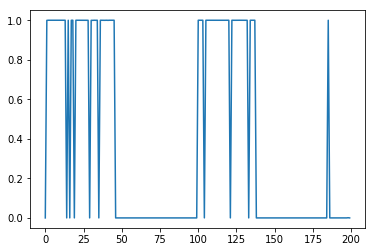

In [83]:
import matplotlib.pyplot as plt
plt.plot(_)
plt.show()

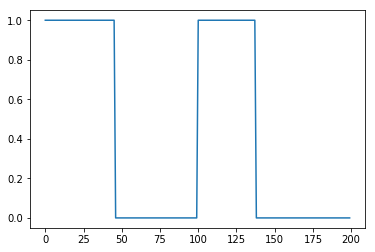

In [84]:
import matplotlib.pyplot as plt
plt.plot(target.cpu().data.numpy().reshape(lenth,))
plt.show()

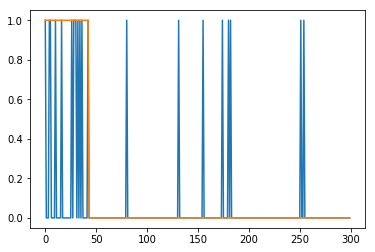

In [98]:
check_in=Variable(torch.FloatTensor(data3[:,:-1]).cuda())
check_out=Variable(torch.FloatTensor(data3[:,-1].reshape(300,1)).cuda())
plt.plot(model(check_in).cpu().data.numpy().reshape(300,))
plt.plot(data3[:,12])
plt.show()

In [93]:
len(_)

300

In [95]:
plt.plot(_.reshape(300,))

AttributeError: 'int' object has no attribute 'reshape'

In [25]:
for param in model.parameters():
    print(param.grad.data)


-8.9646e-10 -3.1003e-09 -2.2022e-09  ...   7.8005e-10 -3.5961e-09  3.8002e-09
-1.6604e-08 -5.7421e-08 -4.0788e-08  ...   1.4448e-08 -6.6604e-08  7.0385e-08
 6.5942e-08  2.2805e-07  1.6199e-07  ...  -5.7379e-08  2.6452e-07 -2.7954e-07
                ...                   ⋱                   ...                
-3.8279e-08 -1.3238e-07 -9.4034e-08  ...   3.3308e-08 -1.5355e-07  1.6227e-07
 3.4063e-08  1.1780e-07  8.3678e-08  ...  -2.9639e-08  1.3664e-07 -1.4440e-07
 8.3670e-08  2.8937e-07  2.0554e-07  ...  -7.2807e-08  3.3564e-07 -3.5470e-07
[torch.cuda.FloatTensor of size 1000x12 (GPU 0)]


1.00000e-07 *
 -0.0292
 -0.5411
  2.1491
    ⋮   
 -1.2475
  1.1101
  2.7269
[torch.cuda.FloatTensor of size 1000 (GPU 0)]


1.00000e-06 *
-0.0061  0.2468 -0.9461  ...   0.5562 -0.4848 -1.2250
[torch.cuda.FloatTensor of size 1x1000 (GPU 0)]


1.00000e-07 *
  3.1097
[torch.cuda.FloatTensor of size 1 (GPU 0)]

